# Showing limitations of our approach

In [53]:
import numpy as np
import random
from tqdm.notebook import tqdm
from copy import deepcopy
import time
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pytorch_lightning as pl
pl.seed_everything(42)

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.reset_orig()

Global seed set to 42


In [54]:
from graph_discovery import GraphDiscoveryMatrix
from utils import matrix_to_order
from causal_graphs.graph_real_world import load_graph_file
from causal_graphs.graph_generation import generate_categorical_graph, generate_chain, generate_random_graph, generate_jungle
from causal_graphs.graph_visualization import visualize_graph
from causal_graphs.graph_utils import adj_matrix_to_edges

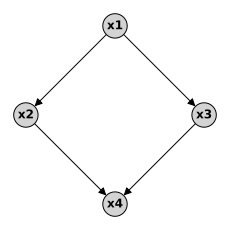

CausalDAG with 4 variables [x1,x2,x3,x4] and 4 edges:
x1 => x2,x3
x2 => x4
x3 => x4



In [116]:
graph = load_graph_file('../causal_graphs/real_data/test_diamond_2.bif')
visualize_graph(graph, show_plot=True, figsize=(3,3))
print(graph)

## Theoretical analysis

In [117]:
p_x1 = graph.variables[0].prob_dist.prob_func.val_grid
p_x2_x1 = graph.variables[1].prob_dist.prob_func.val_grid
p_x3_x1 = graph.variables[2].prob_dist.prob_func.val_grid
p_x4_x2_x3 = graph.variables[3].prob_dist.prob_func.val_grid

In [118]:
p_x2 = (p_x2_x1 * p_x1[:,None]).sum(axis=0)
p_x3 = (p_x3_x1 * p_x1[:,None]).sum(axis=0)
print("p(X_2):", p_x2)
print("p(X_3):", p_x3)

p(X_2): [0.5 0.5]
p(X_3): [0.5 0.5]


In [119]:
p_x1_x2 = (p_x2_x1 * p_x1[:,None] / p_x2[None,:]).T
print("p(X_1|X_2):", p_x1_x2)

p(X_1|X_2): [[0.5 0.5]
 [0.5 0.5]]


In [120]:
p_x3_x2 = (p_x3_x1[None] * p_x1_x2[...,None]).sum(axis=1)
print("p(X_3|X_2):", p_x3_x2)

p(X_3|X_2): [[0.5 0.5]
 [0.5 0.5]]


In [121]:
p_x4 = (p_x4_x2_x3 * p_x2[:,None,None] * p_x3_x2[:,:,None]).sum(axis=(0,1))
print("p(X_4):", p_x4)

p(X_4): [0.5 0.5]


In [122]:
# Verify that the marginals are correct
v = graph.sample(batch_size=100000, as_array=True)
print(v.mean(axis=0))
print(v[v[:,1]==1,3].mean())

[0.49932 0.50075 0.50054 0.50191]
0.5024463305042436


In [123]:
p_x4_x2 = (p_x4_x2_x3 * p_x3_x2[:,:,None]).sum(axis=(1))
print("p(X_4|X_2):", p_x4_x2)

p(X_4|X_2): [[0.5 0.5]
 [0.5 0.5]]


In [124]:
p_x4_dox2 = (p_x4_x2_x3 * p_x3[None,:,None]).sum(axis=(1))
print("p(X_4|do(X_2)):", p_x4_dox2)

p(X_4|do(X_2)): [[0.5 0.5]
 [0.5 0.5]]


In [125]:
def entropy(p1, p2):
    ent = -(p1 * np.log(p2)).sum()
    return ent

In [126]:
p_dox2 = np.array([0.5, 0.5])
p_obs = (p_x4_dox2 * p_dox2[:,None])

In [127]:
print("Lowest entropy:", entropy(p_obs, p_x4_dox2))

Lowest entropy: 0.6931471805599453


In [128]:
print("Entropy p(X_4|X_2):", entropy(p_obs, p_x4_x2))

Entropy p(X_4|X_2): 0.6931471805599453


In [129]:
print("Entropy p(X_4):", entropy(p_obs, p_x4[None]))

Entropy p(X_4): 0.6931471805599453


## Training

In [81]:
discovery_module = GraphDiscoveryMatrix(graph=graph, model_iters=1000, lambda_sparse=0.1, batch_size=128, lr_permut=5e-3, lr_gamma=5e-3,
                                        N_s=1, C_s=200, gamma_iters=100,
                                        order_grads_opt='weight_expect_no_denom_weight_intervention', edge_grads_opt='weight_expect')
discovery_module.to(torch.device("cuda:0"))
print(discovery_module.gamma)

Parameter containing:
tensor([[-9.0000e+15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -9.0000e+15,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -9.0000e+15,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -9.0000e+15]],
       requires_grad=True)


In [28]:
"""
discovery_module.gamma.data = torch.FloatTensor([
    [-9e+15, 5.0, -5.0, -5.0, -5.0, -5.0],
    [-5.0, -9e+15, 5.0, -5.0, -5.0, -5.0],
    [5.0, -5.0, -9e+15, 5.0, -5.0, -5.0],
    [-5.0, -5.0, -5.0, -9e+15, 5.0, -5.0],
    [-5.0, -5.0, -5.0, -5.0, -9e+15, 5.0],
    [-5.0, -5.0, -5.0, -5.0, -5.0, -9e+15],
])
discovery_module.theta_matrix.data = torch.FloatTensor([
    [0.0, 5.0, 0.0, 0.0, 0.0, 0.0],
    [-5.0, 0.0, 5.0, 0.0, 0.0, 0.0],
    [0.0, -5.0, 0.0, 5.0, 0.0, 0.0],
    [0.0, 0.0, -5.0, 0.0, 5.0, 0.0],
    [0.0, 0.0, 0.0, -5.0, 0.0, 5.0],
    [0.0, 0.0, 0.0, 0.0, -5.0, 0.0]
])
"""

'\ndiscovery_module.gamma.data = torch.FloatTensor([\n    [-9e+15, 5.0, -5.0, -5.0, -5.0, -5.0],\n    [-5.0, -9e+15, 5.0, -5.0, -5.0, -5.0],\n    [5.0, -5.0, -9e+15, 5.0, -5.0, -5.0],\n    [-5.0, -5.0, -5.0, -9e+15, 5.0, -5.0],\n    [-5.0, -5.0, -5.0, -5.0, -9e+15, 5.0],\n    [-5.0, -5.0, -5.0, -5.0, -5.0, -9e+15],\n])\ndiscovery_module.theta_matrix.data = torch.FloatTensor([\n    [0.0, 5.0, 0.0, 0.0, 0.0, 0.0],\n    [-5.0, 0.0, 5.0, 0.0, 0.0, 0.0],\n    [0.0, -5.0, 0.0, 5.0, 0.0, 0.0],\n    [0.0, 0.0, -5.0, 0.0, 5.0, 0.0],\n    [0.0, 0.0, 0.0, -5.0, 0.0, 5.0],\n    [0.0, 0.0, 0.0, 0.0, -5.0, 0.0]\n])\n'

In [82]:
discovery_module.gamma.data = torch.FloatTensor([
    [-9e+15, 5.0, 5.0, -5.0],
    [0.0, -9e+15, 0.0, -5.0],
    [0.0, 0.0, -9e+15, -5.0],
    [-5.0, -5.0, -5.0, -9e+15]
])

In [83]:
discovery_module.discover_graph(num_epochs=20)

Gamma - Recall: 50.00%, Precision: 66.67% (TP=2,FP=1,FN=2,TN=7)
Theta - Direction accuracy: 75.00% (TP=3,FN=1) / Soft accuracy: 75.00% (TP=3,FN=1)


Gamma - Recall: 50.00%, Precision: 66.67% (TP=2,FP=1,FN=2,TN=7)
Theta - Direction accuracy: 75.00% (TP=3,FN=1) / Soft accuracy: 75.00% (TP=3,FN=1)


Gamma - Recall: 50.00%, Precision: 66.67% (TP=2,FP=1,FN=2,TN=7)
Theta - Direction accuracy: 75.00% (TP=3,FN=1) / Soft accuracy: 75.00% (TP=3,FN=1)


Gamma - Recall: 50.00%, Precision: 100.00% (TP=2,FP=0,FN=2,TN=8)
Theta - Direction accuracy: 75.00% (TP=3,FN=1) / Soft accuracy: 75.00% (TP=3,FN=1)


KeyboardInterrupt: 

In [ ]:
discovery_module.theta_matrix

In [ ]:
discovery_module.gamma.grad

In [ ]:
torch.round(torch.sigmoid(discovery_module.theta_matrix)*100)